<a href="https://colab.research.google.com/github/AndresMontesDeOca/Redes_Neuronales/blob/main/06_Redes_Neuronales_Conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 06
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Fuentes/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/Redes_Neuronales/Data/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################

Mounted at /content/drive/


## 01 - Ejercicio MINST

Epoch 1/10
300/300 [==============================] - 46s 149ms/step - loss: 0.2837 - accuracy: 0.9189 - val_loss: 0.0765 - val_accuracy: 0.9770
Epoch 2/10
300/300 [==============================] - 43s 143ms/step - loss: 0.0722 - accuracy: 0.9783 - val_loss: 0.0484 - val_accuracy: 0.9846
Epoch 3/10
300/300 [==============================] - 48s 160ms/step - loss: 0.0511 - accuracy: 0.9844 - val_loss: 0.0423 - val_accuracy: 0.9866
Epoch 4/10
300/300 [==============================] - 46s 155ms/step - loss: 0.0406 - accuracy: 0.9874 - val_loss: 0.0328 - val_accuracy: 0.9892
Epoch 5/10
300/300 [==============================] - 43s 142ms/step - loss: 0.0343 - accuracy: 0.9890 - val_loss: 0.0353 - val_accuracy: 0.9877
Epoch 6/10
300/300 [==============================] - 44s 145ms/step - loss: 0.0294 - accuracy: 0.9910 - val_loss: 0.0349 - val_accuracy: 0.9894
Epoch 7/10
300/300 [==============================] - 42s 141ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.0296 - val_ac

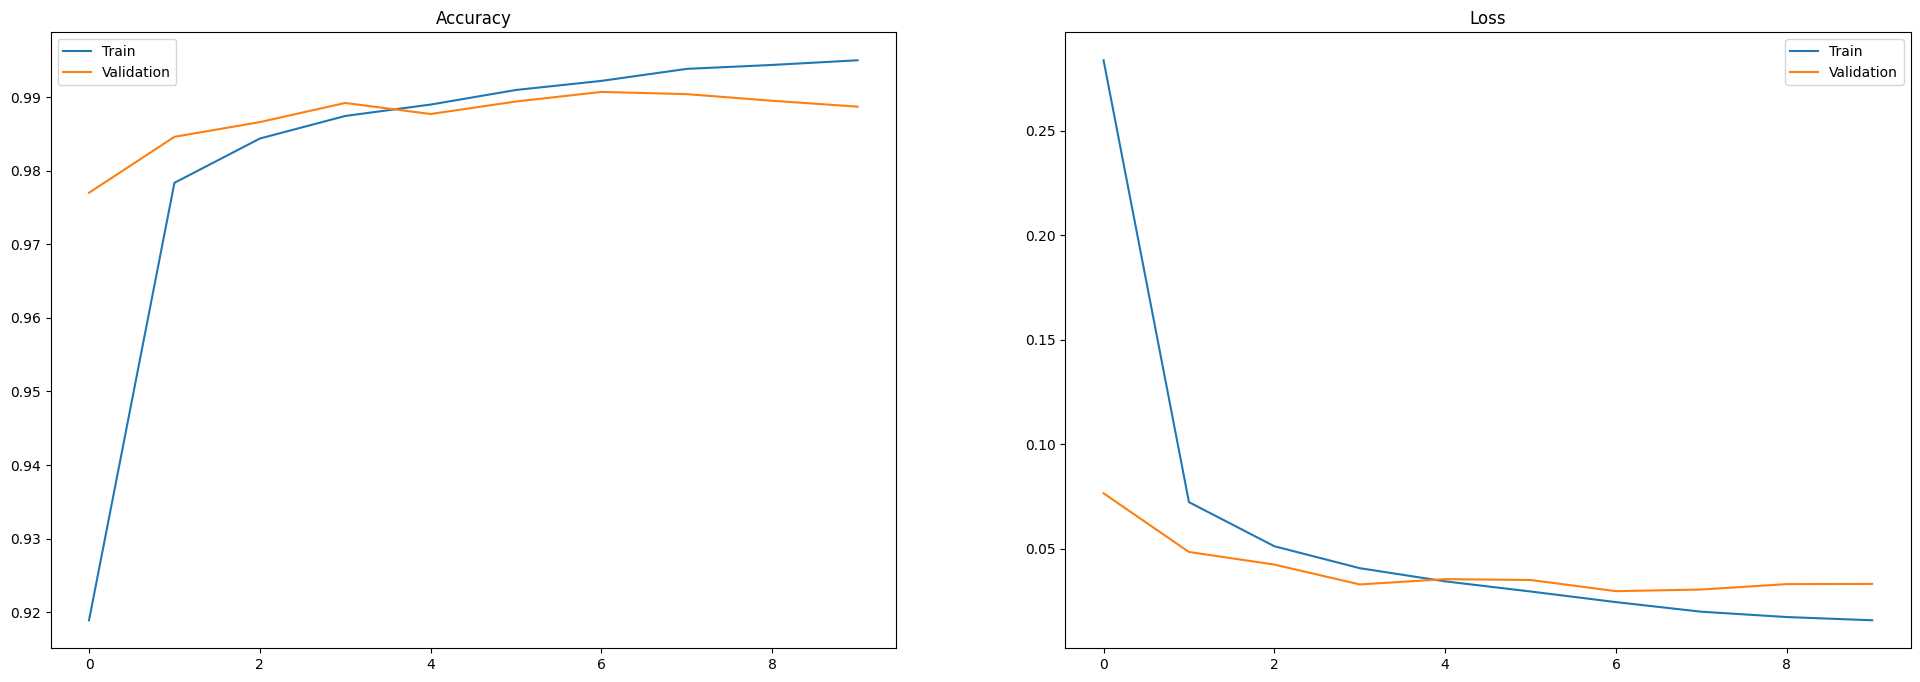

Modelo entrenado y guardado como 'mnist_cnn_model.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# import time
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.regularizers import l1, l2

# from tensorflow.keras.datasets import mnist
# (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# # Redimensionar los datos para que sean compatibles con MinMaxScaler
# X_train = X_train.reshape(-1, 28 * 28)
# X_test = X_test.reshape(-1, 28 * 28)

# # 2. Normalizar los valores de las imágenes a un rango de 0 a 1 utilizando MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Volver a dar forma a los datos para que sean compatibles con la entrada de Conv2D
# X_train = X_train.reshape(-1, 28, 28, 1)
# X_test = X_test.reshape(-1, 28, 28, 1)

# # Convertir las etiquetas a one-hot encoding
# Y_train = to_categorical(Y_train, 10)
# Y_test = to_categorical(Y_test, 10)

# # 3. Construir el modelo CNN
# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(10, activation='softmax')
# ])

# patience = 5

# # Compilar el modelo
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy'])

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=patience,
#     restore_best_weights=True)



# # 4. Entrenar el modelo
# model.fit(
#     X_train,
#     Y_train,
#     validation_data=(X_test, Y_test),
#     epochs=10,
#     callbacks=[early_stop],
#     verbose=1,
#     batch_size=200)

# plot_history(model.history)
# # 5. Guardar el modelo
# model.save('mnist_cnn_model.h5')

# print("Modelo entrenado y guardado como 'mnist_cnn_model.h5'")

# # model.evaluate(X_test, Y_test)

In [ ]:
# # Evaluar el modelo en el conjunto de prueba
# loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)

# print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
# print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

313/313 [==============================] - 2s 7ms/step - loss: 0.0331 - accuracy: 0.9887
Pérdida en el conjunto de prueba: 0.0331
Precisión en el conjunto de prueba: 0.9887


## 03 Fingers

In [ ]:
import zipfile
import os

# # Descomprimir en la misma carpeta
# with zipfile.ZipFile(os.path.join(DATOS_DIR, 'Fingers.zip'), 'r') as zip_ref:
#     zip_ref.extractall(LOCAL_DIR)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt

IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'

def import_data(data_dir):

    img_list = glob.glob(data_dir)      # Obtener la lista de archivos de imágenes
    assert len(img_list) > 0, IMG_ERROR # verifica que la ruta sea correcta y tenga al menos 1 imagen

    img_data = []  # lista de imagenes
    lbl_data = []  # lista de etiquetas

    img_count = len(img_list)
    for i, img_path in enumerate(img_list):

        img = Image.open(img_path)          # Carga imagen
        img = np.array(img) / np.max(img)   # Normaliza los píxeles entre 0 y 1
        img = img.reshape((*img.shape, 1))  # Formatea la imagen para TF: WxH => WxHx1

        # Almacenar la imagen y la etiqueta
        img_data.append(img)
        lbl_data.append(int(img_path[-6]))  # Extrae la cantidad de dedos del nombre del archivo

        # Mostrar progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100 * i / img_count), end="")

    print("\rCargando imágenes: 100.00%% (%d) \n" % img_count)

    return np.array(img_data), np.array(lbl_data)


# carga las imagenes a partir de los nombres de archivos
x_train, y_train = import_data(DATOS_DIR+"Fingers/train/*/*.png")

# carga las imagenes a partir de los nombres de archivos
x_test, y_test = import_data(DATOS_DIR+"Fingers/test/*/*.png")

# separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.30, shuffle = True)


Cargando imágenes:   0.00%

In [ ]:
EPOCAS = 50
LOTES  = 64
PACIENCIA=8
IMG_SIZE = x_train.shape[1:]
N_CLASSES = len(np.unique(y_train))
ACTIVA = 'LeakyReLU'

# Construye el modelo
model = Sequential()

model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = optimizers.Adam(0.001)
# Observar que con "sparse_categorical_crossentropy" no hace falta codificacion one-hot para las clases
model.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True )

# entrena el modelo y guarda la historia del progreso
H = model.fit(x_train,
              y_train,
              batch_size = LOTES,
              epochs = EPOCAS,
              validation_data = (x_val, y_val),
              callbacks=[early_stop]
             )

